<a href="https://colab.research.google.com/github/Mainakdeb/project-jurkat/blob/main/project-jurkat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work in progress

In [2]:
!pip install iterative-stratification

In [ ]:
!pip install optuna

In [ ]:
!wget https://data.broadinstitute.org/bbbc/BBBC048/BBBC048v1.zip
!wget https://data.broadinstitute.org/bbbc/BBBC048/Ground_truth.lst
!unzip "/content/BBBC048v1.zip"
!unzip "/content/CellCycle.zip"

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp /content/drive/MyDrive/models/jurkat/jurkat_res50.pth /content/pretrained_drive.pth

In [9]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from albumentations import *
import torchvision.transforms as transforms
from tqdm.notebook import tnrange, tqdm
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from torchvision import models 
import torch.nn as nn
import torch.optim as optim
import time
import seaborn as sns
import os, csv
from IPython.display import clear_output
import optuna


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [11]:
def preprocess_df(df, save_path):
  dataframe1 = df
  cell_df = pd.DataFrame(list())
  cell_df.to_csv('cell_cycle.csv')

  f=open("cell_cycle.csv",'r+')
  w=csv.writer(f)

  folders = ["Anaphase", "G1", "G2","Metaphase", "Prophase", "S", "Telophase"]
  folders2 = ["G1","G2","S"]

  for f in folders2:
    for path, dirs, files in os.walk("/content/CellCycle/"+f+"/"):
        for filename in files:
            w.writerow([path+filename, f])

  #name columns
  c = pd.read_csv('./cell_cycle.csv', header=None)
  c.columns = ["path","class_name"]
  #print("class names: ",c.class_name.unique())

  #delete non merged rows
  c_merged=c[c.path.str[-10:] == "merged.jpg"]
  c_merged.to_csv(save_path)
  return(c_merged)


In [12]:
def image_to_nparray(path):
    i = cv2.imread(path)
    i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    return(np.array(i))

In [13]:
class C_Dataset(Dataset):
    """custom"""

    def __init__(self, csv, root_dir='',augmentation=None, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = csv
        self.augmentation = augmentation
        self.class_dict = {'G1':0,
                           'S': 1,
                           'G2':2}
        
    def __getitem__(self, idx): 

        smol_img_path = str(self.d.iloc[idx][1]) #image path column
        class_name = str(self.d.iloc[idx][2])  #class name column
        full_img_path = self.root_dir + smol_img_path #+ '.png'
        img_arr = image_to_nparray(full_img_path)

        if self.augmentation is not None:
            img  = self.augmentation(image = img_arr)
            img2 = img["image"]

        if self.transform is not None:
            img_ret = self.transform(img2)
        
        return {"x": img_ret,
                "y": torch.tensor(self.class_dict[str(class_name)])
        }

    def __len__(self):
        return (len(self.d))

In [14]:
def create_subset(input_csv_path, output_csv_path, lower_lim, upper_lim):
  #create a subset
  df = pd.read_csv(input_csv_path)
  df = df.sample(frac=1)
  # iloc[row slicing, column slicing]
  subset_df = df.iloc[lower_lim:upper_lim, 1:]
  subset_df.to_csv(output_csv_path)


In [15]:
def create_folds_from_csv(input_csv_path, output_csv_path):
  #create folds
  df = pd.read_csv(input_csv_path)
  df.loc[:,"kfold"] = -1
  targets = df.drop("class_name", axis=1).values

  NFOLDS = 10
  mskf = MultilabelStratifiedKFold(n_splits = NFOLDS)
  for fold, (trn, val) in enumerate(mskf.split(X=df, y = targets)):
      df.loc[val, "kfold"] = fold
      
  df.to_csv("./train_targets_folds.csv", index=False)


In [16]:
class Engine:
      def __init__(self, model, optimizer, device, scheduler, criterion):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion=criterion

      def train(self, data_loader):
        train_loss = 0.0
        valid_loss = 0.0
        total_tr = 0.0
        correct_tr = 0.0
        self.model.train()
        for batch in tqdm(data_loader, desc="training"):##
          data, target=batch['x'].to(self.device), batch['y'].to(self.device)
          self.optimizer.zero_grad()
          # Forward Pass
          output = self.model(data)
          loss = self.criterion(output, target)
          # Backward Pass  
          loss.backward()
          # Update loss and accuracy
          self.optimizer.step()
          train_loss += loss.item() * data.size(0)
          _,predicted = torch.max(output.data, 1)
          total_tr += target.size(0)
          correct_tr += (predicted == target).sum().item()
        #self.scheduler.step(1.)
        return(train_loss/len(data_loader.sampler), 100*correct_tr/total_tr)

      def evaluate(self, data_loader):
        valid_loss = 0.0
        total_val=0.0
        correct_val=0.0
        self.model.eval()
        for data in data_loader:
            data, target=data['x'].to(self.device), data['y'].to(self.device)
            output = self.model(data)
            loss = self.criterion(output, target)
            valid_loss += loss.item()* data.size(0)
            _,predicted = torch.max(output.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
        return(valid_loss/len(data_loader.sampler), 100*correct_val/total_val)


In [17]:
def run_training(load_pretrained, pretrained_path, fold, batch_size, lr, save_model=True, num_epochs = 1, plot_metrics=True):

    train_csv=pd.read_csv('./train_targets_folds.csv')

    val_fold=train_csv[train_csv['kfold'] == fold]
    train_fold=train_csv[train_csv['kfold'] != fold]
    
    
    train_dataset = C_Dataset(train_fold, 
                 '',
                 augmentation = Compose([ 
                                        RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                #transforms.Resize((128,128)),
                                                transforms.CenterCrop((32,32)),
                                                transforms.RandomHorizontalFlip(), 
                                                transforms.ToTensor()
                                                ])
                )
    valid_dataset = C_Dataset(val_fold, 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                #transforms.Resize((128,128)),
                                                transforms.CenterCrop((32,32)),
                                                transforms.ToTensor()
                                                ])
                )
    
    train_loader = torch.utils.data.DataLoader(
                    train_dataset
                    ,batch_size=batch_size
                    ,shuffle=True
                )

    val_loader = torch.utils.data.DataLoader(
                    valid_dataset
                    ,batch_size=32
                    ,shuffle=True
                )

    torch.cuda.empty_cache()
    model_ft = models.resnet50(pretrained=False)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 3))
    model = model_ft.to(device)

    if load_pretrained:
        model.load_state_dict(torch.load(pretrained_path))
        print("model loaded successfully: ", pretrained_path)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = 0.00001)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min', 
                                                 factor=0.1,
                                                 patience=5, 
                                                 eps=1e-4, 
                                                 verbose=True)
    eng = Engine(model,
                 optimizer, 
                 device='cuda', 
                 scheduler = scheduler,
                 criterion=criterion)
    
    best_loss = 999
    early_stop_iter = 7
    early_stop_count=0
    train_losses_arr=[]
    train_acc_arr=[]
    val_losses_arr=[]
    val_acc_arr=[]

    for epoch in range(num_epochs):

        train_loss, train_accuracy = eng.train(train_loader)
        valid_loss, valid_accuracy = eng.evaluate(val_loader)

        train_losses_arr.append(train_loss)
        val_losses_arr.append(valid_loss)
        train_acc_arr.append(train_accuracy)
        val_acc_arr.append(valid_accuracy)

        #print("epoch:{:.0f} train_loss: {:.3f} valid_loss: {:.3f} train_acc: {:.3f} valid_acc{:.3f}".format(epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))#, "val_loss:", valid_loss)
        
        if valid_loss<best_loss:
            best_loss = valid_loss
            if save_model:
                torch.save(model.state_dict(), "model_"+str(fold)+".pth")
        else:
            early_stop_count +=1
            
        if early_stop_count>early_stop_iter:
            break

        if plot_metrics:
            clear_output(wait=True)
            print("fold {:.0f} epoch:{:.0f} train_loss: {:.3f} valid_loss: {:.3f} train_acc: {:.3f}% valid_acc: {:.3f}%".format(fold+1, epoch+1, train_loss, valid_loss, train_accuracy, valid_accuracy))#, "val_loss:", valid_loss)
            
            plt.plot(train_losses_arr, 'r',label="train_loss")
            plt.plot(val_losses_arr, 'g',label="valid_loss")
            plt.xlabel("iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

            plt.plot(train_acc_arr, 'r',label="train_accuracy")
            plt.plot(val_acc_arr, 'g',label="valid_accuracy")
            plt.xlabel("iterations")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show()

    torch.save(model.state_dict(), "model_final.pth")                
    return(best_loss)
    #to do: accuracy

In [18]:
def plot_dict_pie(df, column_name, title):
    dt = (dict(df[column_name].value_counts()))
    dictionary=dt
    slices = list(dictionary.values())
    activities = list(dictionary.keys())
    plt.pie(slices,
            labels=activities,
            startangle=90,
            shadow= True,
            #explode=(0,0.2,0,0, 0, 0, 0, 0, 0, 0),
            autopct='%1.1f%%')

    plt.title(title)
    plt.show()


def balance_df(df, cls):
    max_size = df[cls].value_counts().max()
    lst = [df]
    for class_index, group in df.groupby(cls):
        lst.append(group.sample(max_size-len(group), replace=True))
    frame_new = pd.concat(lst)
    df2=frame_new
    df3=df2.sample(frac=1) # randomise
    return(df3.iloc[:,1:])


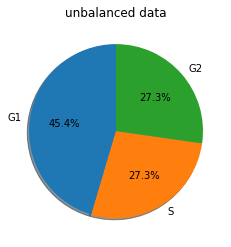

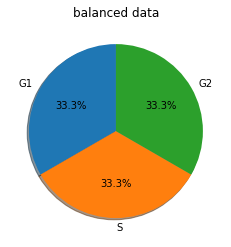

In [19]:
merged_df=preprocess_df(df=pd.read_csv("/content/Ground_truth.lst",header=None),
                        save_path="cell_merged.csv")

df_m=pd.read_csv("cell_merged.csv")
plot_dict_pie(df_m, "class_name", "unbalanced data")

balanced_df=balance_df(df_m, "class_name")
plot_dict_pie(balanced_df, "class_name", "balanced data")
balanced_df.to_csv("cell_merged_balanced.csv")

create_subset(input_csv_path="/content/cell_merged_balanced.csv",
              output_csv_path="cell_merged_subset.csv",
              lower_lim=0,
              upper_lim=29000)

create_folds_from_csv(input_csv_path='/content/cell_merged_subset.csv',
                      output_csv_path='./train_targets_folds.csv')

In [20]:
#optuna
def objective(trial):
    params = {
        "lr": trial.suggest_uniform("lr", 5e-4 , 5e-3 ),
        "batch_size" : trial.suggest_int("batch_size", 16 , 64)

    }

    loss_  = run_training(
        load_pretrained=False,
        pretrained_path="pretrained_drive.pth",
        fold=0,
        batch_size = params["batch_size"],
        lr = params["lr"],
        num_epochs = 2,
        plot_metrics=False
    )
    return loss_

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

fold 10 epoch:12 train_loss: 0.274 valid_loss: 0.359 train_acc: 88.785% valid_acc: 86.310%


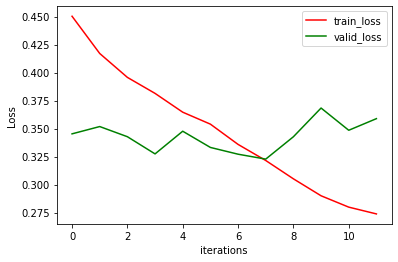

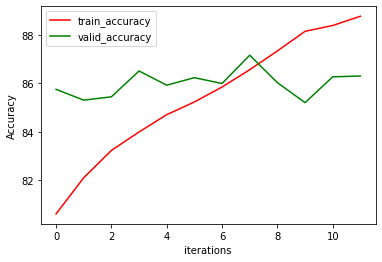

In [21]:
best_losses = []
NFOLDS=10
#train one fold
for fold in range(NFOLDS):
    best_losses.append(
        run_training(
            load_pretrained=True,
            pretrained_path="pretrained_drive.pth",
            fold=fold,
            batch_size = 128, #best_params["batch_size"],
            lr = 0.0001, #best_params["lr"],
            num_epochs = 30,
            plot_metrics=True
        )
    )

In [22]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(num_ftrs, 3))
model = model_ft.to(device)
model.load_state_dict(torch.load("model_final.pth"))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


<All keys matched successfully>

In [36]:
all_models = [model for i in range(10)]

for i in range (len(all_models)):
    
    name = "./model_" + str(i) + ".pth"
    all_models[i].load_state_dict(torch.load(name))
    all_models[i].to(device)
    print("Loaded: ", name)

def model_jury(models_list, images):
  preds=[]
  for model in models_list:
    model=model.eval()
    pred=model(images).detach().cpu().numpy()
    preds.append(pred)
  return(torch.from_numpy(np.mean(preds, axis=0)))

Loaded:  ./model_0.pth
Loaded:  ./model_1.pth
Loaded:  ./model_2.pth
Loaded:  ./model_3.pth
Loaded:  ./model_4.pth
Loaded:  ./model_5.pth
Loaded:  ./model_6.pth
Loaded:  ./model_7.pth
Loaded:  ./model_8.pth
Loaded:  ./model_9.pth


In [37]:
#test on hold out set

create_subset(input_csv_path="/content/cell_merged.csv",
              output_csv_path="cell_merged_hold_out.csv",
              lower_lim=29000,
              upper_lim=31503)

data_holdout = C_Dataset(pd.read_csv('/content/cell_merged_hold_out.csv'), 
                 '',
                 augmentation = Compose([ 
                                        #RandomBrightnessContrast( p=0.9),
                                        #Rotate(limit=30, interpolation=1, border_mode=4, always_apply=True, p=0.9)
                                        ]),
                transform = transforms.Compose([    
                                                transforms.ToPILImage(),
                                                #transforms.Resize((128,128)),
                                                transforms.CenterCrop((32,32)),
                                                transforms.ToTensor()
                                                ])
)

dl_holdout = torch.utils.data.DataLoader(
    data_holdout
    ,batch_size=32
    ,shuffle=True
    # ,pin_memory=True
    # ,num_workers=4
)

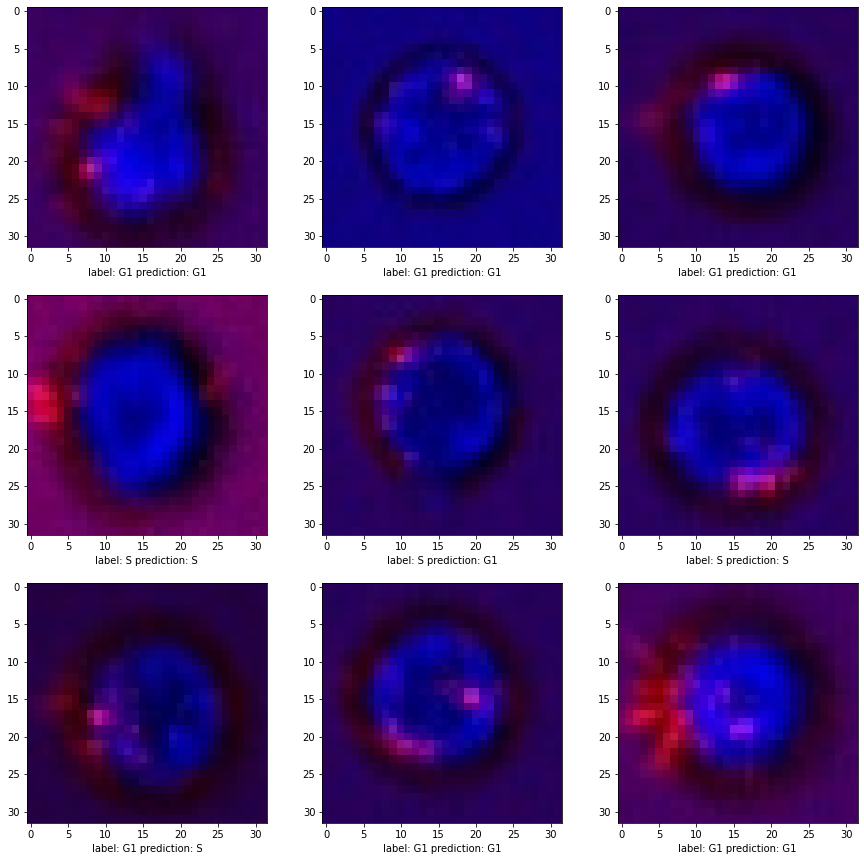

In [38]:
def viz_preds(list_models, num_models, data_loader):
    fig, ax = plt.subplots(3,3, figsize = (15,15))
    torch.cuda.empty_cache()
    class_dict={'G1':0,
                'S': 1,
                'G2':2}
    available_models=list_models[0:num_models]

    for i in range (9):
        data = next(iter(data_loader))
        image, label = data['x'], data['y'].to(device)
        #print(label)
        #image[0]=np.clip(image[0], 0, 1)
        ax.flat[i].imshow(image[0].permute(1,2,0))
        batch_output= model_jury(available_models,image.to(device))
            
        _,batch_prediction=torch.max(batch_output.data, 1)
        image_pred=batch_prediction[0].item()
    
        text = "label: "+list(class_dict.keys())[int(label[0])] +" prediction: "+list(class_dict.keys())[int(image_pred)]
        ax.flat[i].set_xlabel(text)

viz_preds(list_models=all_models, num_models=1, data_loader=dl_holdout)

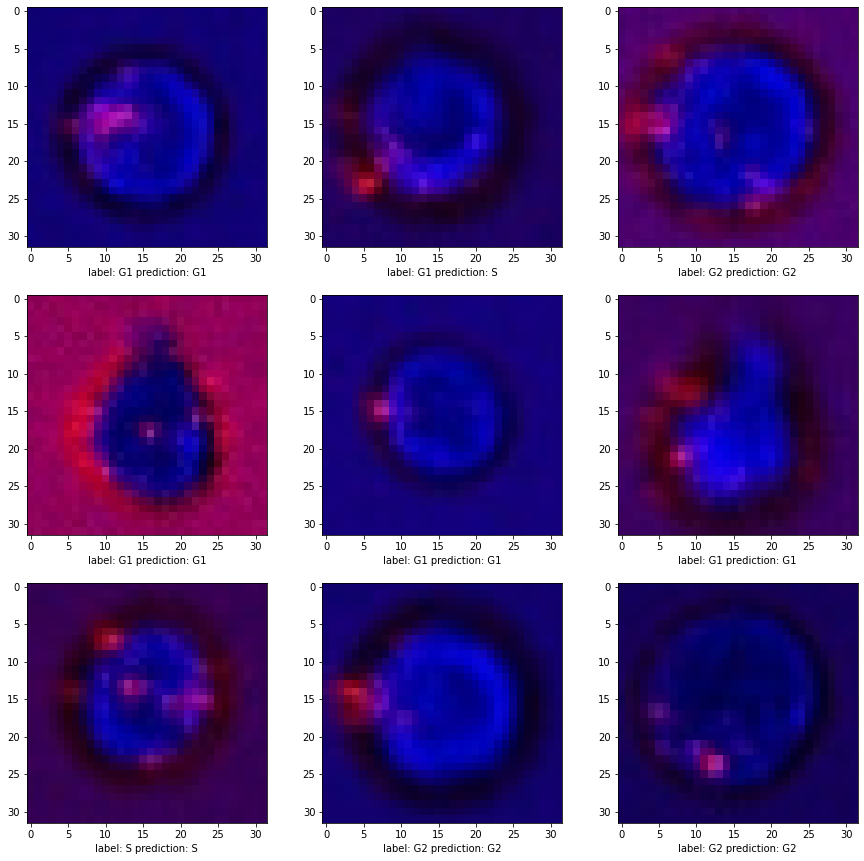

In [39]:
viz_preds(list_models=all_models, num_models=10, data_loader=dl_holdout)

10
accuracy: 87.535 %


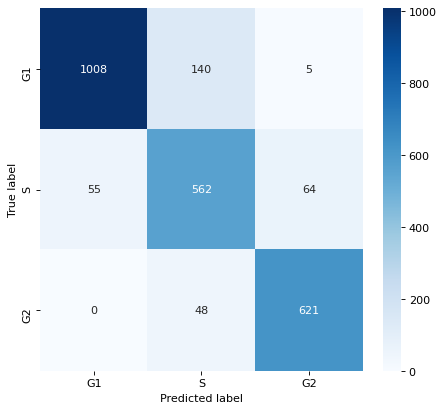

In [40]:
#conf matrix
def plot_conf_matrix(list_models, num_models, data_loader):
    class_names =  ['G1', 'S', 'G2']
    confusion_matrix = torch.zeros(len(class_names), len(class_names))
    available_models=list_models[0:num_models]
    print(len(available_models))

    with torch.no_grad():
        for i, data in enumerate(data_loader, 0):
            images, labels = data['x'].to(device), data['y'].to(device)
            outputs = model_jury(available_models,images)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    cm = confusion_matrix.numpy()
    fig = plt.figure(figsize=(6.5,6),  dpi = 80)
    ax = sns.heatmap(cm,
                    annot=True, 
                    cmap='Blues', 
                    xticklabels = class_names, 
                    yticklabels = class_names, 
                    fmt='g')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    total_correct=np.trace(cm)
    total=np.sum(cm)
    print("accuracy: {:.3f}".format(100*total_correct/total), "%")

plot_conf_matrix(list_models=all_models, num_models=10, data_loader=dl_holdout)

1
accuracy: 87.535 %


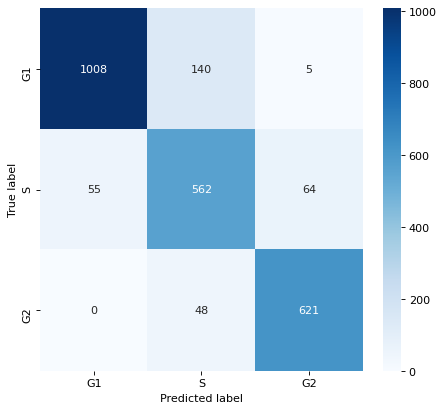

In [41]:
plot_conf_matrix(list_models=all_models, num_models=1, data_loader=dl_holdout)

In [42]:
!pip install tsne
import tsne
from tsne import bh_sne
 
model.cpu()
model.eval()
tsne_dir = "/content/"

out_label, out_data, out_output = [], [], []

for batch in dl_holdout: 
  data, target=batch['x'], batch['y']
  # Get predictions on the validation data 
  output = model(data)

  # Convert data to numpy and append to list
  output_np = output.data.cpu().numpy()
  label_np = target.data.cpu().numpy()
  data_np = data.data.cpu().numpy()
  
  out_output.append(output_np)
  out_label.append(label_np[:, np.newaxis])
  out_data.append(np.squeeze(data_np))

  output_array = np.concatenate(out_output, axis=0)
  label_array  = np.concatenate(out_label, axis=0)
  data_array   = np.concatenate(out_data, axis=0)

In [43]:
#!pip install umap-learn
import umap 

# Get UMAP predictions
reducer = umap.UMAP(n_neighbors = 200, n_components = 2, metric = 'minkowski')
embedding = reducer.fit_transform(output_array.astype(np.float64))

# Transform UMAP predictions into dataframes for visualization
names = np.unique(label_array)
umap_output_df = pd.DataFrame(embedding)
label_df = pd.DataFrame(label_array)
dataset = pd.concat([umap_output_df, label_df],axis=1)

# Get labels for class keys
label_dic = class_dict
label_dic = {value:key for key, value in label_dic.items()}

# Visualize UMAP predictions
plt.figure(figsize =(5,5),  dpi = 150)
for i in range(len(np.unique(label_array))):
  data = dataset[dataset.iloc[:,2] == i]
  plt.scatter(data.iloc[:,0], data.iloc[:,1],  alpha=0.4, label =label_dic.get(i), marker= 'o', s = 0.8)
plt.legend(fontsize=12)
plt.savefig(os.path.join(tsne_dir, 'UMAP_3classes.png'), bbox_inches='tight')
plt.show()

NameError: ignored

In [ ]:
!cp /content/model_0.pth /content/drive/MyDrive/models/base_transfer/model_0_w.pth
!cp /content/model_1.pth /content/drive/MyDrive/models/base_transfer/model_1_w.pth
!cp /content/model_2.pth /content/drive/MyDrive/models/base_transfer/model_2_w.pth
!cp /content/model_3.pth /content/drive/MyDrive/models/base_transfer/model_3_w.pth
!cp /content/model_4.pth /content/drive/MyDrive/models/base_transfer/model_4_w.pth
!cp /content/model_5.pth /content/drive/MyDrive/models/base_transfer/model_5_w.pth
!cp /content/model_6.pth /content/drive/MyDrive/models/base_transfer/model_6_w.pth
!cp /content/model_7.pth /content/drive/MyDrive/models/base_transfer/model_7_w.pth
!cp /content/model_8.pth /content/drive/MyDrive/models/base_transfer/model_8_w.pth
!cp /content/model_9.pth /content/drive/MyDrive/models/base_transfer/model_9_w.pth

In [ ]:
!cp /content/model_final.pth /content/drive/MyDrive/models/jurkat/jurkat_res50_w.pth